In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()
df1 = pd.read_csv("/content/drive/MyDrive/Projects/DS201/data/traffic_new.csv")

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [44]:
df.sample()

,segment_id,2022-10-01 0:00,2022-10-01 1:00,2022-10-01 2:00,2022-10-01 3:00,2022-10-01 4:00,2022-10-01 5:00,2022-10-01 6:00,2022-10-01 7:00,2022-10-01 8:00,...,2022-10-20 14:00,2022-10-20 15:00,2022-10-20 16:00,2022-10-20 17:00,2022-10-20 18:00,2022-10-20 19:00,2022-10-20 20:00,2022-10-20 21:00,2022-10-20 22:00,2022-10-20 23:00
186,-17040019253766,1.626575,1.512027,1.122566,0.641466,0.801833,1.260023,2.359679,2.932417,5.475372,...,8.797251,9.896907,9.186712,8.476518,9.117984,8.545246,7.42268,7.033219,5.658648,3.963345


In [47]:
df = df1[df1["segment_id"] == -17040019253766]

In [48]:
data_start_date = df.columns[1]
data_end_date = df.columns[-1]
print('Data ranges from %s to %s' % (data_start_date, data_end_date))

Data ranges from 2022-10-01 0:00 to 2022-10-20 23:00


In [49]:
def plot_random_series(df, n_series):

    sample = df.sample(n_series, random_state=8)
    id_labels = sample['segment_id'].tolist()
    series_samples = sample.loc[:,data_start_date:data_end_date]

    plt.figure(figsize=(10,6))

    for i in range(series_samples.shape[0]):
        np.log1p(pd.Series(series_samples.iloc[i]).astype(np.float64)).plot(linewidth=1.5)

    plt.title('Randomly Selected segment_id	of road Over Time (Log(views) + 1)')
    plt.legend(id_labels)

plot_random_series(df, 6)

ValueError: Cannot take a larger sample than population when 'replace=False'

In [50]:
from datetime import timedelta

pred_steps = 14
pred_length = timedelta(hours=pred_steps)

first_hour = pd.to_datetime(data_start_date)
last_hour = pd.to_datetime(data_end_date + " 23:00:00")

val_pred_start = last_hour - pred_length + timedelta(hours=1)
val_pred_end = last_hour
print("Validation Prediction Period:", val_pred_start, "to", val_pred_end)

train_pred_start = val_pred_start - pred_length
train_pred_end = val_pred_start - timedelta(hours=1)
print("Training Prediction Period:", train_pred_start, "to", train_pred_end)

enc_length = train_pred_start - first_hour
print("Encoding Period Length:", enc_length)

train_enc_start = first_hour
train_enc_end = train_enc_start + enc_length - timedelta(hours=1)
print("Training Encoding Period:", train_enc_start, "to", train_enc_end)

val_enc_start = train_enc_start + pred_length
val_enc_end = val_enc_start + enc_length - timedelta(hours=1)
print("Validation Encoding Period:", val_enc_start, "to", val_enc_end)

Validation Prediction Period: 2022-10-20 10:00:00 to 2022-10-20 23:00:00
Training Prediction Period: 2022-10-19 20:00:00 to 2022-10-20 09:00:00
Encoding Period Length: 18 days 20:00:00
Training Encoding Period: 2022-10-01 00:00:00 to 2022-10-19 19:00:00
Validation Encoding Period: 2022-10-01 14:00:00 to 2022-10-20 09:00:00


In [51]:
date_to_index = pd.Series(index=pd.Index([pd.to_datetime(c) for c in df.columns[1:]]),
                          data=[i for i in range(len(df.columns[1:]))])

series_array = df[df.columns[1:]].values.astype(np.float32)
print(series_array)

def get_time_block_series(series_array, date_to_index, start_date, end_date):
    inds = date_to_index[start_date:end_date]
    return series_array[:,inds]

def transform_series_encode(series_array):
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_mean = series_array.mean(axis=1).reshape(-1,1)
    series_array = series_array - series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))

    return series_array, series_mean

def transform_series_decode(series_array, encode_series_mean):
    series_array = np.log1p(np.nan_to_num(series_array)) # filling NaN with 0
    series_array = series_array - encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))

    return series_array

[[ 1.626575    1.5120275   1.1225659   0.6414662   0.80183274  1.2600229
   2.3596792   2.932417    5.4753723   6.3917527   8.4536085   8.476518
   8.705613    7.995418    7.9495993   7.7892327   7.010309    8.774342
   9.828178    8.2932415   7.1935854   6.9644904   4.833906    2.7720504
   1.809851    1.626575    1.4432989   0.8476518   0.82474226  1.0996563
   1.489118    2.703322    4.123711    5.7044673   7.628866    6.9873996
   7.033219    7.033219    8.132875    8.087056    9.003436   10.194731
   9.667812    8.224513    7.3768616   6.414662    4.788087    2.3596792
   1.4662085   1.214204    0.82474226  0.6185567   1.0767468   1.672394
   3.619702    4.3757157   5.429553    8.4536085   7.812142    7.90378
   8.430698    8.064147    8.522337    8.270332    9.003436    7.6059566
   9.530355    8.178694    7.353952    5.2462773   3.9633448   2.3138602
   1.2829324   0.9163803   0.80183274  0.68728524  0.9392898   1.3287514
   2.7720504   4.3528066   5.8877435   7.7892327   7.9266

In [52]:
first_n_samples = 100
batch_size = 2**11
epochs = 100

encoder_input_data = get_time_block_series(series_array, date_to_index,
                                           train_enc_start, train_enc_end)[:first_n_samples]


encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)


decoder_target_data = get_time_block_series(series_array, date_to_index,
                                            train_pred_start, train_pred_end)[:first_n_samples]

decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)


encoder_input_val_data = get_time_block_series(series_array, date_to_index, val_enc_start, val_enc_end)
encoder_input_val_data, encode_series_mean = transform_series_encode(encoder_input_val_data)

decoder_target_val_data = get_time_block_series(series_array, date_to_index, val_pred_start, val_pred_end)
decoder_target_val_data = transform_series_decode(decoder_target_val_data, encode_series_mean)

In [53]:
!pip install tensorflow_datasets

import tensorflow_datasets as tfds
import tensorflow as tf

import time
import numpy as np
import matplotlib.pyplot as plt

In [54]:
train_dataset = tf.data.Dataset.from_tensor_slices((encoder_input_data, decoder_target_data))
val_dataset = tf.data.Dataset.from_tensor_slices((encoder_input_val_data, decoder_target_val_data))

In [55]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates


def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)

    # apply sin to even indices in the array; 2i
    sines = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    cosines = np.cos(angle_rads[:, 1::2])

    pos_encoding = np.concatenate([sines, cosines], axis=-1)

    pos_encoding = pos_encoding[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

In [56]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # add extra dimensions so that we can add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
print(create_padding_mask(x))

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

x = tf.random.uniform((1, 4))
temp = create_look_ahead_mask(x.shape[1])
print(temp)

tf.Tensor(
[[[[0. 0. 1. 1. 0.]]]


 [[[0. 0. 0. 1. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(3, 1, 1, 5), dtype=float32)
tf.Tensor(
[[0. 1. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]], shape=(4, 4), dtype=float32)


In [57]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
      q, k, v must have matching leading dimensions.
      The mask has different shapes depending on its type(padding or look ahead)
      but it must be broadcastable for addition.

    Args:
        q: query shape == (..., seq_len_q, depth)
        k: key shape == (..., seq_len_k, depth)
        v: value shape == (..., seq_len_v, depth)
        mask: Float tensor with shape broadcastable
            to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
        output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_v, depth)

    return output, attention_weights

In [58]:
def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(
        q, k, v, None)
    print ('Attention weights are:')
    print (temp_attn)
    print ('Output is:')
    print (temp_out)

np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 3)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [59]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v) # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size) #(batch_size, num_head, seq_len_v, depth)
        # scaled_attention.shape == (batch_size, num_heads, seq_len_v, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_v, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_v, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_v, d_model)

        return output, attention_weights

In [60]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

In [61]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

In [62]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

In [63]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.BatchNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.BatchNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask) # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1) # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output) # (batch_size, input_seq_len, d_model)

        return out2

In [64]:
# Encoder Layer Test
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

In [65]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.BatchNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.BatchNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.BatchNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,
            look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)

        return out3, attn_weights_block1, attn_weights_block2

In [66]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output,
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

In [67]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, max_len=5000,
                rate=0.1):
        super(Encoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = tf.keras.layers.Dense(d_model, use_bias=False)
        self.pos_encoding = positional_encoding(max_len, self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        # adding embedding and position encoding
        x = self.embedding(x)
        # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x

In [68]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048)

sample_encoder_output = sample_encoder(tf.random.uniform((64, 62,1)),
                                       training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


In [69]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, max_len=5000, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Dense(d_model, use_bias=False)
        self.pos_encoding = positional_encoding(max_len, self.d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                            for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,
                look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                  look_ahead_mask, padding_mask)
            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2



        return x, attention_weights

In [70]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048)

output, attn = sample_decoder(tf.random.uniform((64, 26,3)),
                              enc_output=sample_encoder_output,
                              training=False, look_ahead_mask=None,
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

In [71]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, out_dim, max_len=5000,
                rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                              max_len, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                               max_len, rate)

        self.final_layer = tf.keras.layers.Dense(out_dim)

    def call(self, inp, tar, training, enc_padding_mask,
             look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)

        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        final_output = self.final_layer(dec_output)

        return final_output, attention_weights

In [72]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048,
    out_dim=1)

temp_input = tf.random.uniform((64, 62,1))
temp_target = tf.random.uniform((64, 23,1))

fn_out, _ = sample_transformer(temp_input, temp_target,training=False,
                               enc_padding_mask=None,
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape

TensorShape([64, 23, 1])

In [73]:
num_layers = 1
d_model = 64
dff = 256
num_heads = 4

dropout_rate = 0.2
input_sequence_length = 452 # Length of the sequence used by the encoder
target_sequence_length = 10 # Length of the sequence predicted by the decoder
batch_size = 2*11

train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

In [74]:
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 452, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 14, 1), dtype=tf.float32, name=None))>

In [75]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [76]:
optimizer = tf.keras.optimizers.Adam(2e-5, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

Text(0.5, 0, 'Train Step')

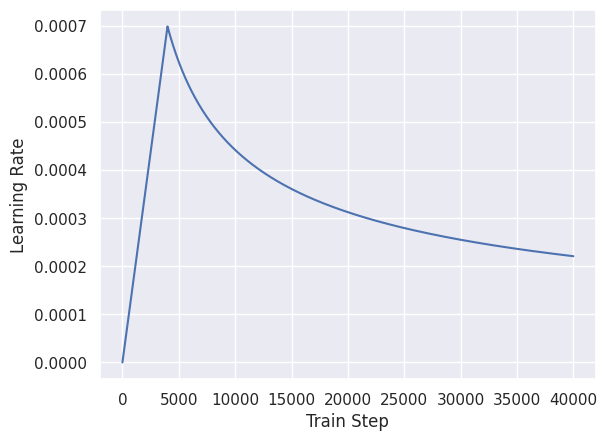

In [32]:
temp_learning_rate_schedule = CustomSchedule(512)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [77]:
# Loss and metrics
loss_object = tf.keras.losses.MeanAbsoluteError()

In [78]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [79]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
#train_accuracy = tf.keras.metrics.mean_absolute_error()

test_loss = tf.keras.metrics.Mean(name='test_loss')

In [80]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          out_dim=1, rate=dropout_rate)

In [81]:
def create_masks(inp, tar):
    inp = inp.reshape()
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

In [82]:
# check point
checkpoint_path = "/content/drive/MyDrive/Projects/DS201/source_codes/checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [83]:
def train_step(inp, tar):
    last_inp = tf.expand_dims(inp[:,0,:],-1)
    tar_inp = tf.concat([last_inp, tar[:,:-1,:]], axis=1)
    tar_real = tar

    #enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
    #print(enc_padding_mask)
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])

    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp,
                                     True,
                                     None,
                                     look_ahead_mask,
                                     None)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    #train_accuracy(tar_real, predictions)

In [84]:
EPOCHS = 100

In [85]:
for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
    test_loss.reset_states()
    #train_accuracy.reset_states()

    for (batch, (inp, tar)) in enumerate(train_dataset):
        #print(tf.shape(inp))
        train_step(inp, tar)

        #if batch % 100 == 0:
        #    print ('Epoch {} Batch {} Train Loss {:.4f} '.format(
        #        epoch + 1, batch, train_loss.result()))
                #, train_accuracy.result()))

    # validation:
    #for (batch, (inp, tar)) in enumerate(val_dataset):
        #print(inp, tar)
    #    test_step(inp, tar)

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

    print ('Epoch {} Train Loss {:.4f}'.format(epoch + 1,
                                                train_loss.result()))
                                                #train_accuracy.result()))
    #print ('Epoch {} Test Loss {:.4f}'.format(epoch + 1,
    #                                      test_loss.result()))
    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Train Loss 0.3671
Time taken for 1 epoch: 2.605574369430542 secs

Epoch 2 Train Loss 0.4560
Time taken for 1 epoch: 0.23362159729003906 secs

Epoch 3 Train Loss 0.4874
Time taken for 1 epoch: 0.30562734603881836 secs

Epoch 4 Train Loss 0.5465
Time taken for 1 epoch: 0.4709310531616211 secs

Saving checkpoint for epoch 5 at /content/drive/MyDrive/Projects/DS201/source_codes/checkpoints/train/ckpt-21
Epoch 5 Train Loss 0.4518
Time taken for 1 epoch: 0.402315616607666 secs

Epoch 6 Train Loss 0.4603
Time taken for 1 epoch: 0.6319980621337891 secs

Epoch 7 Train Loss 0.6288
Time taken for 1 epoch: 0.3329346179962158 secs

Epoch 8 Train Loss 0.4965
Time taken for 1 epoch: 1.2671618461608887 secs

Epoch 9 Train Loss 0.4307
Time taken for 1 epoch: 1.280364751815796 secs

Saving checkpoint for epoch 10 at /content/drive/MyDrive/Projects/DS201/source_codes/checkpoints/train/ckpt-22
Epoch 10 Train Loss 0.4191
Time taken for 1 epoch: 0.8879072666168213 secs

Epoch 11 Train Loss 0.4844
Ti

In [86]:
def test_step(inp, tar):
    #print(inp)
    #print(tar)
    last_inp = tf.expand_dims(inp[:,0,:],-1)
    #print(last_inp)
    tar_inp = tf.concat([last_inp, tar[:,:-1,:]], axis=1)
    tar_real = tar

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    predictions, _ = transformer(inp, tar_inp,
                                     False,
                                     None,
                                     look_ahead_mask,
                                     None)
    loss = loss_function(tar_real, predictions)
    test_loss(loss)

In [87]:
MAX_LENGTH = target_sequence_length

def evaluate(inp):
    encoder_input = inp
    #print(encoder_input)
    output = tf.expand_dims(encoder_input[:,-1,:],-1)
    #print(output)

    for i in range(MAX_LENGTH):
        look_ahead_mask = create_look_ahead_mask(tf.shape(output)[1])
        predictions, attention_weights = transformer(encoder_input,
                                                     output,
                                                     False,
                                                     None,
                                                     look_ahead_mask,
                                                     None)

        # select the last word from the seq_len dimension
        predictions = predictions[: ,-1:, :]  # (batch_size, 1)
        #print("pred:", predictions) #
        output = tf.concat([output, predictions], axis=1)
        #print(output)

    return tf.squeeze(output, axis=0), attention_weights

In [88]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
def predict_and_plot(encoder_input_data, decoder_target_data, sample_ind, enc_tail_len=50):

    encode_series = encoder_input_data[sample_ind:sample_ind+1,:,:]
    #print(encode_series)

    pred_series, _ = evaluate(encode_series)
    pred_series = np.array([pred_series])
    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)[1:,:]
    target_series = decoder_target_data[sample_ind,:,:1].reshape(-1,1)

    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]

    mse = mean_squared_error(target_series, pred_series)
    r2 = r2_score(target_series, pred_series)
    mae = mean_absolute_error(target_series, pred_series)

    plt.figure(figsize=(10,6))

    plt.plot(range(1,x_encode+1),encode_series_tail)
    plt.plot(range(x_encode,x_encode+pred_steps),target_series,color='orange')
    plt.plot(range(x_encode,x_encode+pred_steps),pred_series,color='teal',linestyle='--')

    plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions\nMSE: %.4f, MAE: %.4f, R2: %.4f' % (enc_tail_len, mse, mae, r2))
    plt.legend(['Encoding Series','Target Series','Predictions'])

(1, 452, 1)

In [ ]:
predict_and_plot(encoder_input_val_data, decoder_target_val_data, 23)